In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/akshay/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

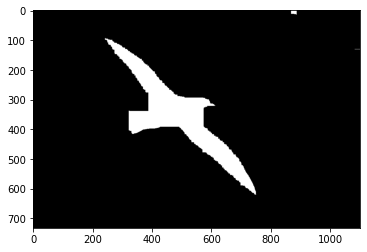

In [2]:
image = "../data/bird.jpg"
img = cv2.imread(image)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

edge = cv2.Canny(img,240,255)
dilated = cv2.dilate(edge,None,iterations = 20)
eroded = cv2.erode(dilated,None,iterations = 30)
plt.imshow(eroded,cmap="gray")

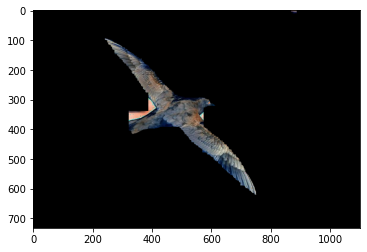

In [3]:
masked = img.copy()
for i in range(3):
    masked[:,:,i] = img[:,:,i]*eroded
plt.imshow(masked)

In [4]:
import cv2
import numpy as np
import sys,os
from tqdm import tqdm

# script_dir = sys.path[0] # This gives the directory in which our script is running on the system
# img_path = os.path.join(script_dir, '../data/'+sys.argv[1])


def im2double(im,d):
    #im1,im2,im3 = cv2.split(im)
#     out = im.copy()
#     for i in range(d):
#         out[:,:,i] = (out[:,:,i] - np.min(out[:,:,i]))/(np.max(out[:,:,i])-np.min(out[:,:,i]))
    
    im1 = im[:,:,0]
    im2 = im[:,:,1]
    im3 = im[:,:,2]
    out1 = (im1.astype(np.float64) - np.min(im1.ravel())) / (np.max(im1.ravel()) - np.min(im1.ravel()))
    out2 = (im2.astype(np.float64) - np.min(im2.ravel())) / (np.max(im2.ravel()) - np.min(im2.ravel()))
    out3 = (im3.astype(np.float64) - np.min(im3.ravel())) / (np.max(im3.ravel()) - np.min(im3.ravel()))
    out = cv2.merge((out1,out2,out3))
    return out

def meanShift(img):
    r,c,d = img.shape
    img = im2double(img,d)
    gaussian_blur = cv2.GaussianBlur(img, (5,5), 1.0)
    
    #hsv_image = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    #h,s,v = cv2.split(hsv_image)
#     row = r//2
#     col = row
    row,col = 128,128
    newimg = cv2.resize(img,(row,col))

    
    result1 = np.zeros((row,col))
    result2 = np.zeros((row,col))
    result3 = np.zeros((row,col))
    h=0.1
    sigma = 11.0 
    count = 0
    window_size = 7
    padded = np.concatenate((np.concatenate((np.zeros((row,window_size,3)), newimg),axis=1), np.zeros((row,window_size,3))),axis=1)

    padded = np.concatenate((np.concatenate((np.zeros((window_size,col+2*(window_size),3)),padded),axis=0), np.zeros((window_size, col+2*(window_size),3))),axis=0)
    #padded = np.zeros((row+2*window_size,col+2*window_size))
    r,c,d = padded.shape
    #r,c = padded.shape
    print(padded.shape)

    #isotropic
    #Spatial
    spatial = np.zeros((2*window_size+1,2*window_size+1))
    for is1 in range(2*window_size+1):
        for is2 in range(2*window_size+1):
            spatial[is1][is2] = ((is1-window_size)**2+(is2-window_size)**2)**0.5
    spatial = np.exp(-(spatial/sigma)**2)

    
    for idx1 in tqdm(range(window_size,r-window_size)):
        for idx2 in range(window_size,c-window_size):
            window = padded[idx1-window_size:idx1+window_size+1, idx2-window_size:idx2+window_size+1]
            #print(newimg[idx1][idx2])
            (x1,x2,x3) = newimg[idx1-window_size][idx2-window_size]
            N1 = 0.0 #numerator
            D1 = 1.0 #denominator
            N2 = 0.0 #numerator
            D2 = 1.0 #denominator
            N3 = 0.0 #numerator
            D3 = 1.0 #denominator


            for itern in range(30): # number of iterations
                for idx3 in range(2*window_size+1):
                    for idx4 in range(2*window_size+1):
                        (x_i1,x_i2,x_i3) = window[idx3][idx4]
                        diff1 = abs(x1-x_i1)
                        diff2 = abs(x2-x_i2)
                        diff3 = abs(x3-x_i3)

                        d1 = np.exp(-(diff1/h)**2)*spatial[idx3][idx4]
                        n1 = x_i1*d1
                        N1 += n1
                        D1 += d1

                        d2 = np.exp(-(diff2/h)**2)*spatial[idx3][idx4]
                        n2 = x_i2*d2
                        N2 += n2
                        D2 += d2

                        d3 = np.exp(-(diff3/h)**2)*spatial[idx3][idx4]
                        n3 = x_i3*d3
                        N3 += n3
                        D3 += d3

                x1 = float(N1)/D1 # in each iteration, x changes
                x2 = float(N2)/D2 # in each iteration, x changes
                x3 = float(N3)/D3 # in each iteration, x changes

            result1[idx1-window_size][idx2-window_size] = x1
            result2[idx1-window_size][idx2-window_size] = x2
            result3[idx1-window_size][idx2-window_size] = x3

#             if count%1000 == 0:
#                 print(count)
#             count += 1
    '''
    cv2.imshow('Original Image',spatial)
    print(spatial)
    '''
    result = cv2.merge((result1,result2,result3))
    #print(result)
    return result,newimg

In [5]:
# img = cv2.imread("../data/bird.jpg") # Read image here
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# meanShift(img)

  0%|          | 0/128 [00:00<?, ?it/s]

(142, 142, 3)


100%|██████████| 128/128 [32:15<00:00, 15.12s/it]


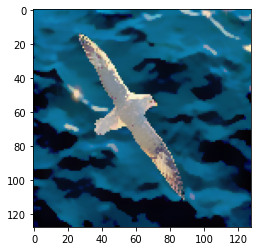

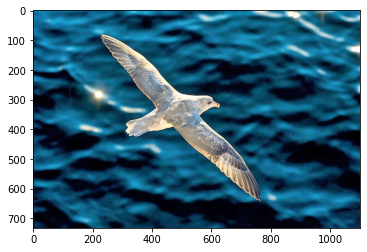

In [6]:
img = cv2.imread("../data/bird.jpg") # Read image here
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
result2,resized_image = meanShift(img)
plt.figure()
plt.imshow(result2)
plt.figure()
plt.imshow(img)

(732, 1100, 3)


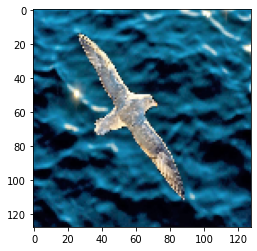

In [7]:
resized_orig = cv2.resize(img,(128,128))
plt.imshow(resized_orig)
print(img.shape)

In [ ]:
flower_img = cv2.imread("../data/flower.jpg") # Read image here
flower_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
result1,resized_flower = meanShift(flower_img)
plt.figure()
plt.imshow(resized_flower)
plt.figure()
plt.imshow(flower_img)

  0%|          | 0/128 [00:00<?, ?it/s]

(142, 142, 3)


 10%|█         | 13/128 [03:16<29:14, 15.25s/it]

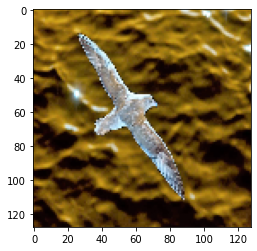

In [99]:
plt.imshow(resized_flower)

100%|██████████| 128/128 [00:00<00:00, 7244.44it/s]


[(0.665027, 6285), (0.30663, 10097)]
2


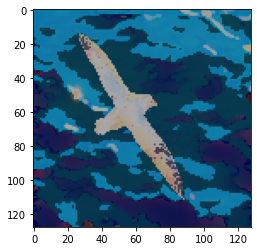

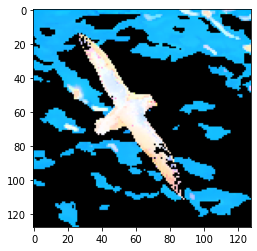

In [8]:
#print(np.unique(result[:,:,0]))
masked = np.zeros_like(result2)
# for i in range(3):
#     for j in range(64):
#         for k in range(64):
#             if result[j,k,i]>0.7:
#                 masked[j,k,i] = 1
#             else:
#                 masked[j,k,i] = 0

unique_intensities ={}

result = (result2).astype(np.float32)
#print(result.shape)

hsv_result = cv2.cvtColor(result,cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(hsv_result)

r,c = v.shape
diff = np.zeros_like(v)

for i in tqdm(range(r)):
    for j in range(c):
        inten = v[i,j]
        flag=0
        if inten not in unique_intensities:
            diff = 999999
            intensity = 0
            for k in unique_intensities:
                if abs(inten-k)<0.35:
                    flag=1
                    if diff>abs(inten-k):
                        diff = abs(inten-k)
                        intensity=k 
                    v[i,j] = intensity
            if flag==0:
                unique_intensities[inten] = 0
            else:
                unique_intensities[intensity] += 1
        else:
            unique_intensities[inten] += 1

sort =sorted(unique_intensities.items(), key = lambda kv:(kv[1], kv[0])) 
print(sort)
h_copy = np.ones_like(h)
s_copy = np.ones_like(s)
v_copy = v.copy()
for i in tqdm(range(r)):
    for j in range(c):
        if v_copy[i,j]==sort[-1][0]:
            v_copy[i,j] = 0
        else:
            v_copy[i,j] = 1


"""
for z in range(3):
    for i in range(64):
        for j in range(64):
            inten = result[i,j,z]
            flag=0
            if inten not in unique_intensities:
                for k in unique_intensities:
                    if abs(inten-k)<0.25:
                        masked[i,j,z] = k
                        flag=1
                        break
                if flag==0:
                    unique_intensities.append(inten) 

"""
masked = cv2.merge((h,s,v))
masked_2 = cv2.merge((h,s,v_copy))
masked = cv2.cvtColor(masked,cv2.COLOR_HSV2RGB)
masked_2 = cv2.cvtColor(masked_2,cv2.COLOR_HSV2RGB)
plt.figure()
plt.imshow(masked)
plt.figure()
plt.imshow(masked_2)
print(len(unique_intensities))
# for key,value in unique_intensities.items():
#     print(key," : ", value)
#print(np.unique(masked,axis=0))

In [9]:
# print(result2.shape)
# print(((sort[-1][0])**3)*0.05)
# r,col,d = result2.shape
# result_copy = np.zeros_like(result2)
# for i in range(r):
#     for j in range(col):
#         a,b,c = result_copy[i,j,:]
#         #print(a*b*c)
#         if a*b*c<=(((sort[0][0])**3)):
#             result_copy[i,j,:] = 0

# plt.imshow(result_copy)

(128, 128)
1611


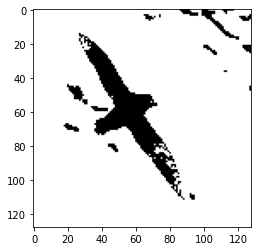

In [10]:
r,c,d = masked_2.shape
vectorized_mask = np.zeros((r,c))
foreground_pixels = []
for i in range(r):
    for j in range(c):
            vectorized_mask[i,j] = masked_2[i,j,0] * masked_2[i,j,1] * masked_2[i,j,2]
            if vectorized_mask[i,j]>0.4:   #0.02 works for flower , 0.4 for bird
                vectorized_mask[i,j]=0
                foreground_pixels.append((i,j))
            else:
                vectorized_mask[i,j]=1
print(vectorized_mask.shape)

plt.imshow(vectorized_mask,cmap='gray')
print(len(foreground_pixels))
#print(vectorized_mask)

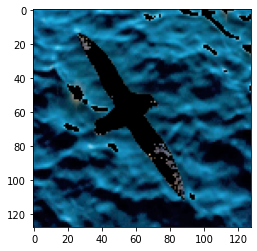

In [11]:
masked_img = np.zeros((result2.shape[0],result2.shape[1],3))
masked_img[:,:,0] = resized_orig[:,:,0]*vectorized_mask
masked_img[:,:,1] = resized_orig[:,:,1]*vectorized_mask
masked_img[:,:,2] = resized_orig[:,:,2]*vectorized_mask
masked_img = masked_img/np.max(masked_img)
plt.imshow(masked_img)

100%|██████████| 128/128 [00:58<00:00,  2.20it/s]


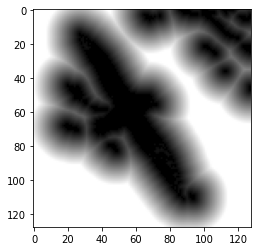

In [89]:
# find distance from the background to foreground
masked_image_distance = np.zeros_like(masked_img)
masked_image_kern_sizes = np.ones_like(masked_img)*5

kern_size = lambda sigma: int(round(((sigma-0.8)/0.3+1)*2+1 )) if sigma >0.8 else 0

for i in tqdm(range(r)):
    for j in range(c):
        distance_min = 9999999
        for k in foreground_pixels:
            if ((i-k[0])**2+(j-k[1])**2)<distance_min**2:
                distance_min = np.sqrt((i-k[0])**2+(j-k[1])**2)
                masked_image_distance[i,j,:] = distance_min
                #masked_image_kern_sizes[i,j,:] = kern_size(distance_min)
        if distance_min>=20:
            masked_image_distance[i,j,:] = 20
            #masked_image_kern_sizes[i,j,:] = kern_size(6.99)
        

plt.figure()
plt.imshow(masked_image_distance/masked_image_distance.max())
# plt.figure()
# plt.imshow(masked_image_kern_sizes/masked_image_kern_sizes.max())

In [13]:
# print(np.min(masked_image_kern_sizes))
print(np.unique(masked_image_distance))

[0.         1.         1.41421356 2.         2.23606798 2.82842712
 3.         3.16227766 3.60555128 4.         4.12310563 4.24264069
 4.47213595 5.        ]


In [14]:
from numpy import sqrt,e,power,linspace,outer,pi

def dnorm(x,mu,sigma):
    return 1 / (sqrt(2 * pi) * sigma) * e ** (-power((x - mu) / sigma, 2) / 2)

def gaussian_kernel(ksize,mu=0,sigma=1,verbose=False):
    # create the 1-D gaussian kernel
    if ksize%2==0:
        ksize = ksize-1
    
    kernel_1D = linspace(-(ksize // 2), ksize // 2, ksize)
    for i in range(ksize):
        kernel_1D[i] = dnorm(kernel_1D[i], mu, sigma)

    # computers outer product of two 1-D gaussian kernels
    # to produce a 2D Gaussian Kernel
    kernel_2D = outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / kernel_2D.max()
    return kernel_2D


def convolution(image, kernel_distances,kernel_size=11):
    #print("Kernel Shape : {}".format(kernel.shape))

    # EXTRACTING THE IMAGE AND KERNEL SHAPES AND INITIALIZING OUTPUT
    image_row, image_col,dim = image.shape
    print(image_row,image_col)
    
    
    
    output = np.zeros_like(image)
    # CREATING ZERO-PADDED IMAGE
    
    pad_height = int((kernel_size - 1) / 2)
    pad_width = int((kernel_size - 1) / 2)
    padded_image = np.ones((image_row + (2 * pad_height), image_col + (2 * pad_width),3))*image[0,0,0]
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width,:] = image
    
    plt.figure()
    plt.imshow(padded_image/np.max(padded_image))
    
    padded_row,padded_col,_ = padded_image.shape
    print(padded_image.shape)
    print("Image Coords :",pad_height,":",padded_image.shape[0] - pad_height, pad_width,":",padded_image.shape[1] - pad_width)
    #print(padded_height-pad_height-1,padded_width-pad_width-1)
    #print(padded_image.shape[0] - pad_height,padded_image.shape[1] - pad_width)
    
    #for row in tqdm(range(pad_height,padded_height-pad_height-1)):
        #for col in range(pad_width,padded_width-pad_width-1):
    for row in tqdm(range(pad_height,padded_row-pad_height)):
        for col in range(pad_width,padded_col-pad_width):
            #print(kernel_sizes[row,col,0])
            #print(row-25,col-25)
#             if kernel_sizes[row-pad_height,col-pad_width,0]>2:
#                 kernel = gaussian_kernel(int(kernel_sizes[row-pad_height,col-pad_width,0]),kernel_distances[row-pad_height,col-pad_width,0])
#                 kernel_row, kernel_col = kernel.shape
#                 output[row-pad_height, col-pad_width,:] = cv2.GaussianBlur(padded_image[row:row + kernel_row, col:col + kernel_col,:],(int(kernel_sizes[row-pad_height,col-pad_width,0]),int(kernel_sizes[row-pad_height,col-pad_width,0])),kernel_distances[row-pad_height,col-pad_width,0])
            #print("row: {} and col: {}".format(row,col))
            if kernel_distances[row-pad_height,col-pad_width,0]>0:
                kernel = gaussian_kernel(kernel_size,kernel_distances[row-pad_height,col-pad_width,0])
                kernel_row, kernel_col = kernel.shape
                
                kernel_mid = kernel_row//2
                #print("Here : kernel_mid :: ",kernel_mid)
                
#                 min_truncate = min(min(row,image_row-row-1),min(col,image_col-col-1))
#                 print(row,col,kernel_mid,kernel_row,kernel_col,sep="::")
#                 print(min_truncate, end="  ")
#                 print(row,col)
                
#                 if min_truncate>0 and kernel_row<=row and kernel_col<=col:
#                     for i in range(3):
#                         output[row, col,i] = np.sum(kernel * image[row-kernel_mid:row+kernel_mid+1, col-kernel_mid:col + kernel_mid+1,i])
                
#                 elif min_truncate>0 and not (kernel_row<=row or kernel_col<=col) :
                #kernel_truncated = kernel[kernel_mid-min_truncate:kernel_mid+min_truncate+1,kernel_mid-min_truncate:kernel_mid+min_truncate+1]
                #kernel_row, kernel_col = kernel_truncated.shape
                #print(row,,col,kernel_col+col)
                # check for paddings if necessary
                #print("Kernel Sizes : ",kernel_row,kernel_col)
                for i in range(3):
                    output[row-pad_height,col-pad_width,i] = np.sum(kernel * padded_image[row-pad_height:row +kernel_mid+1, col-pad_width:col + kernel_mid+1,i])
#                 else:
#                     output[row, col,:] = image[row,col,:]
            else:
                output[row-pad_height,col-pad_width,:] = padded_image[row,col,:]

    return output

In [90]:
def gaussian_kernel(ksize,mu=0,sigma=1,verbose=False):
    # create the 1-D gaussian kernel
    if ksize%2==0:
        ksize = ksize+1
    
    kernel_1D = linspace(-(ksize // 2), ksize // 2, ksize)
    for i in range(ksize):
        kernel_1D[i] = dnorm(kernel_1D[i], mu, sigma)

    # computers outer product of two 1-D gaussian kernels
    # to produce a 2D Gaussian Kernel
    kernel_2D = outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / np.sum(kernel_2D)
    #print(kernel_2D)
    return kernel_2D



def convolution(image, kernel_distances):

    image_row, image_col,dim = image.shape
    print(image_row,image_col) 
        
    output = np.zeros_like(image)
    
    plt.figure()
    plt.imshow(image/np.max(image))
    
    padded_row,padded_col,_ = image.shape
    print(image.shape)
    
    for row in tqdm(range(padded_row)):
        for col in range(padded_col):
            
            min_truncate = min(min(row,padded_row-row-1),min(col,padded_col-col-1))
            kernel_size = min(min_truncate,kern_size(kernel_distances[row,col,0]))
            
            if kernel_size!=0:
                kernel = gaussian_kernel(kernel_size+2,sigma=kern_size(kernel_distances[row,col,0]))
                #print(row,col,kernel.shape,row+kernel.shape[0])
                for i in range(3):
                    output[row,col,i] = np.sum(kernel *image[row-kernel.shape[0]//2:row+kernel.shape[0]//2+1, col-kernel.shape[1]//2:col + kernel.shape[1]//2+1,i])
            else:
                for i in range(3):
                    output[row,col,i] = image[row,col,i]
                                         
            
    return output

  4%|▍         | 5/128 [00:00<00:02, 41.41it/s]

128 128
(128, 128, 3)


100%|██████████| 128/128 [00:06<00:00, 21.33it/s]


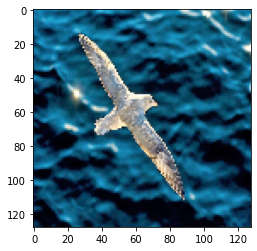

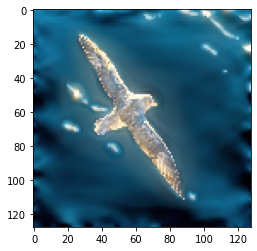

In [91]:
gaussian_blurred = convolution(resized_orig,masked_image_distance)
plt.figure()
#plt.imshow(gaussian_blurred/np.max(gaussian_blurred))
plt.imshow(gaussian_blurred)
# plt.figure()
# plt.imshow(resized_orig-gaussian_blurred,cmap="jet")
# plt.colorbar()